# Explicando Vector DBs

Neste exemplo, vamos criar uma tabela, carregar alguns textos e procurar por similaridade.

Utilizaremos os modelos da OpenAI para gerar embeddings e respostas.

Os dados vetorizados serão armazenados no Astra/Cassandra para busca baseada na similaridade de vetores (Vector Search).

## Configurando ambiente

Inicialmente, vamos instalar e configurar o ambiente para execução dos modelos

In [ ]:
pip install openai cassio --upgrade 

In [51]:
# Carregando variáveis de ambiente
from dotenv import load_dotenv, find_dotenv
import os
load_dotenv(find_dotenv(), override=True)

True

## Conectando ao Astra/Cassandra

Para utilizar o Cassandra como Vector DB, crie um banco de dados com suporte a vvector search em astra.datastax.com, gere um token de conexão e identifique o seu DB ID. Com isso, execute o comando abaixo para criar a conexão

In [52]:
import cassio

cassio.init(token=os.environ["ASTRA_DB_APPLICATION_TOKEN"], database_id=os.environ["ASTRA_DB_ID"])

Pronto!

A conexão com o Astra é muito simples e você já pode armazenar seus documentos.

# Vector Search 101

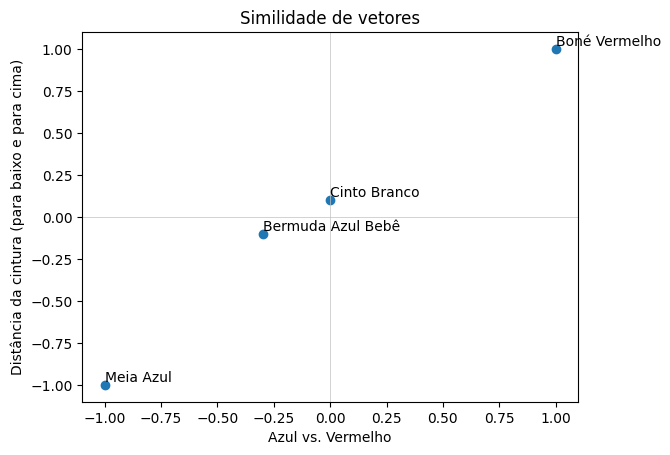

In [102]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Meia Azul',  'Cinto Branco', 'Boné Vermelho', 'Bermuda Azul Bebê']
data = np.array([[-1, -1], 
                 [0, 0.1], 
                 [1, 1], 
                 [-0.3, -0.1]])

x = data[:, 0].astype(float)
y = data[:, 1].astype(float)
plt.scatter(x, y)
plt.xlabel('Azul vs. Vermelho')
plt.ylabel('Distância da cintura (para baixo e para cima)')
for i, name in enumerate(labels):
    plt.text(x[i], y[i], name, ha='left', va='bottom')

plt.title('Similidade de vetores')
plt.axhline(0, color='silver', linewidth=0.5)
plt.axvline(0, color='silver', linewidth=0.5)
plt.show()

In [118]:
from sklearn.metrics.pairwise import cosine_similarity
v1 = data[0]
v2 = data[3]
v1 = v1.reshape(1, -1)
v2 = v2.reshape(1, -1)
cosine_similarity_score = cosine_similarity(v1, v2)
print(f"Similaridade de Coseno {v1} e {v2}:", cosine_similarity_score[0][0])

Similaridade de Coseno [[-1. -1.]] e [[-0.3 -0.1]]: 0.8944271909999157


In [113]:
# Distância Dot Product

referencia = np.array(data[3]).astype(float)

dot_products = []
for ix, row in enumerate(data[0:3]):
    coordinates = row.astype(float)
    dot_product = np.dot(coordinates, reference_element)
    dot_products.append((labels[ix], dot_product))

# sorted_dot_products = sorted(dot_product, key=lambda x: x[1])
# Print the dot products
for label, dot_product in dot_products:
    print(f"Dot product entre {label} e {labels[3]}: {dot_product}")

Dot product entre Meia Azul e Bermuda Azul Bebê: 0.4
Dot product entre Cinto Branco e Bermuda Azul Bebê: -0.020000000000000004
Dot product entre Boné Vermelho e Bermuda Azul Bebê: -0.4


In [110]:
v1 = data[0]
v2 = data[3]
dot_product = np.dot(v1, v2)
dot_product
norm_v1 = np.linalg.norm(v1)
norm_v2 = np.linalg.norm(v2)
cosine_similarity = dot_product / (norm_v1 * norm_v2)
print(f"Similaridade de Coseno {v1} e {v2}:", cosine_similarity)

Similaridade de Coseno [-1. -1.] e [-0.3 -0.1]: 0.8944271909999159


In [112]:
# Normalizando a distância

# Find the minimum and maximum distances
min_distance = min(dist for _, dist in distances)
max_distance = max(dist for _, dist in distances)

# Normalize the distances
normalized_distances = []
for label, distance in distances:
    normalized_distance = ((distance - min_distance) / (max_distance - min_distance)) 
    normalized_distances.append((label, normalized_distance))

# Print the normalized distances
for label, normalized_distance in sorted(normalized_distances, key=lambda x: x[1]):
    print(f"Normalized distance between entre {label} e {labels[3]}': {normalized_distance}")

Normalized distance between entre Cinto Branco e Bermuda Azul Bebê': 0.0
Normalized distance between entre Meia Azul e Bermuda Azul Bebê': 0.6000000000000001
Normalized distance between entre Boné Vermelho e Bermuda Azul Bebê': 1.0


In [ ]:
# Distância Euclideana

referencia = np.array(data[3][0:2]).astype(float)

distancias = []
for ix, row in enumerate(data[0:3]):
    coord = row.astype(float)
    distancia = np.linalg.norm(coord - referencia)
    distancias.append((labels[ix], distancia))

for ix, distancia in sorted(distancias, key=lambda x: x[1]) :
    print(f"Distância Euclideana entre {ix} e {labels[3]}: {distancia}")


In [69]:
from sklearn.metrics.pairwise import cosine_similarity

# Defina o elemento de referência
referencia = np.array(data[3][0:2]).astype(float)

# Extraia os valores numéricos das coordenadas
coordinates = data[:3, :2].astype(float)

# Calcule a similaridade de cosseno entre cada elemento e o elemento de referência
cosine_similarities = cosine_similarity(coordinates, reference_element.reshape(1, -1))

# Converta as similaridades de cosseno em distâncias de cosseno (1 - similaridade)
cosine_distances = 1 - cosine_similarities

# Imprima as distâncias de cosseno
for i, label in enumerate(data[:3, 2]):
    print(f"Distância de Cosseno entre '{label}' e 'Meia Azul': {cosine_distances[i, 0]}")

# Normalize as distâncias de cosseno usando Min-Max scaling
min_distance = np.min(cosine_distances)
max_distance = np.max(cosine_distances)
normalized_distances = 1-((cosine_distances - min_distance) / (max_distance - min_distance))

# Imprima as distâncias de cosseno normalizadas
for i, label in enumerate(data[:3, 1]):
    print(f"Distância de Cosseno Normalizada entre '{label}' e 'Meia Azul': {normalized_distances[i, 0]}")

Distância de Cosseno entre 'Meia Azul' e 'Meia Azul': 2.220446049250313e-16
Distância de Cosseno entre 'Cinto Branco' e 'Meia Azul': 1.0
Distância de Cosseno entre 'Boné Vermelho' e 'Meia Azul': 1.9999999999999998
Distância de Cosseno Normalizada entre '-1' e 'Meia Azul': 1.0
Distância de Cosseno Normalizada entre '0' e 'Meia Azul': 0.5
Distância de Cosseno Normalizada entre '1' e 'Meia Azul': 0.0


In [117]:
# Criando a tabela
from cassio.table.tables import MetadataVectorCassandraTable

vector_table = MetadataVectorCassandraTable(
    keyspace="demo",
    table="vestuario_vector",
    vector_dimension=2,
)
vector_table.clear()
for ix, row in enumerate(data):
    vector_table.put(
        body_blob=labels[ix],
        vector=row[:2].astype(float),
        row_id=str(ix),
        metadata={"id": str(ix)}
    )

In [96]:
# Distância Euclideana

referencia = np.array(data[3][0:2]).astype(float)

distancias = []
for ix, row in enumerate(data[0:3]):
    coord = row.astype(float)
    distancia = np.linalg.norm(coord - referencia)
    distancias.append((labels[ix], distancia))

for ix, distancia in sorted(distancias, key=lambda x: x[1]) :
    print(f"Distância Euclideana entre {ix} e {labels[3]}: {distancia}")


Distância Euclideana entre Cinto Branco e Bermuda Azul Bebê: 0.31622776601683794
Distância Euclideana entre Meia Azul e Bermuda Azul Bebê: 1.140175425099138
Distância Euclideana entre Boné Vermelho e Bermuda Azul Bebê: 1.7029386365926402


## Criando a tabela/índice no Astra

A estrutura no banco de dados que vai armazenar os dados, no caso do Astra/Cassandra, são as tabelas.

O Astra possui uma modelagem baseada em partições que permite escalar os dados até terabytes e milhões de registros.

Além disso, os índices possibilitam queries com suporte a vector search, como veremos a seguir

In [4]:
# Criando a tabela
from cassio.table.tables import MetadataVectorCassandraTable

vector_table = MetadataVectorCassandraTable(
    keyspace="demo",
    table="product_vector",
    vector_dimension=1536,
)

## Embeddings

Vamos converter nossa base de documentos em embeddings. 

Se você não sabe o que são embeddings, assista aqui: https://www.youtube.com/watch?v=fvRyziDmvoA

Vamos gerar embeddings para 2 produtos

In [12]:
# Inicializando a OpenAI
import openai
openai.api_key = os.environ["OPENAI_API_KEY"]

def generate_embedding(text):
    model = "text-embedding-ada-002"
    response = openai.Embedding.create(model=model, input=text)
    return response.data[0]['embedding']


In [15]:
rs = vector_table.get(row_id=product_id)
rs["body_blob"]

'iphone 15, 256GB, Azul'

## Inserindo produtos

In [16]:
product_description = "iphone 15, 256GB, Azul"
product_id = "prod1"
vector_table.put_async(
    body_blob=product_description,
    vector=generate_embedding(product_description),
    row_id=product_id,
    metadata={"id": product_id}
)

#Verificando se o registro foi inserido
rs = vector_table.get(row_id=product_id)
rs["body_blob"]

'iphone 15, 256GB, Azul'

In [17]:
product_description = "Cadeira Gamer Giratória Royale Com Regulagem de Altura Preto/Cinza"
product_id = "prod2"
vector_table.put_async(
    body_blob=product_description,
    vector=generate_embedding(product_description),
    row_id=product_id,
    metadata={"id": product_id}
)

#Verificando se o registro foi inserido
rs = vector_table.get(row_id=product_id)
rs["body_blob"]

'Cadeira Gamer Giratória Royale Com Regulagem de Altura Preto/Cinza'

## Agora que já inserimos 2 produtos, vamos buscar por similaridade

In [21]:
q = "Smartphone cinza"
results = vector_table.ann_search(n=1, vector=generate_embedding(q))
for r in results:
    print(r['body_blob'])

iphone 15, 256GB, Azul
